<a href="https://colab.research.google.com/github/anju456789/Fmml-labs/blob/main/FMML_M1L3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augmentation

FMML Module 1, Lab 3

In this lab, we will see how augmentation of data samples help in improving the machine learning performance. Augmentation is the process of creating new data samples by making reasonable modifications to the original data samples. This is particularly useful when the size of the training data is small. We will use the MNISt dataset for this lab. We will also reuse functions from the previous labs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp

rng = np.random.default_rng(seed=42)

In [2]:
# loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()

# normalizing the data
train_X = train_X / 255
test_X = test_X / 255

# subsample from images and labels. Otherwise it will take too long!
train_X = train_X[::1200, :, :].copy()
train_y = train_y[::1200].copy()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Let us borrow a few functions from the previous labs:

In [3]:
def NN1(traindata, trainlabel, query):
    """
    This function takes in the training data, training labels and a query point
    and returns the predicted label for the query point using the nearest neighbour algorithm

    traindata: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    trainlabel: numpy array of shape (n,) where n is the number of samples
    query: numpy array of shape (d,) where d is the number of features

    returns: the predicted label for the query point which is the label of the training data which is closest to the query point
    """
    diff = (
        traindata - query
    )  # find the difference between features. Numpy automatically takes care of the size here
    sq = diff * diff  # square the differences
    dist = sq.sum(1)  # add up the squares
    label = trainlabel[np.argmin(dist)]
    return label


def NN(traindata, trainlabel, testdata):
    """
    This function takes in the training data, training labels and test data
    and returns the predicted labels for the test data using the nearest neighbour algorithm

    traindata: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    trainlabel: numpy array of shape (n,) where n is the number of samples
    testdata: numpy array of shape (m,d) where m is the number of test samples and d is the number of features

    returns: the predicted labels for the test data which is the label of the training data which is closest to each test point
    """
    traindata = traindata.reshape(-1, 28*28)
    testdata = testdata.reshape(-1, 28*28)
    predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
    return predlabel


def Accuracy(gtlabel, predlabel):
    """
    This function takes in the ground-truth labels and predicted labels
    and returns the accuracy of the classifier

    gtlabel: numpy array of shape (n,) where n is the number of samples
    predlabel: numpy array of shape (n,) where n is the number of samples

    returns: the accuracy of the classifier which is the number of correct predictions divided by the total number of predictions
    """
    assert len(gtlabel) == len(
        predlabel
    ), "Length of the ground-truth labels and predicted labels should be the same"
    correct = (
        gtlabel == predlabel
    ).sum()  # count the number of times the groundtruth label is equal to the predicted label.
    return correct / len(gtlabel)

In this lab, we will use the image pixels themselves as features, instead of extracting features. Each image has 28*28 pixels, so we will flatten them to 784 pixels to use as features. Note that this is very compute intensive and will take a long time. Let us first check the baseline accuracy on the test set without any augmentations. We hope that adding augmentations will help us to get better results.

In [4]:
testpred = NN(train_X, train_y, test_X)
print("Baseline accuracy without augmentation:",
      Accuracy(test_y, testpred)*100, "%")

Baseline accuracy without augmentation: 64.72 %


Let us try to improve this accuracy using augmentations. When we create augmentations, we have to make sure that the changes reflect what will naturally occur in the dataset. For example, we should not add colour to our samples as an augmentation because they do not naturally occur. We should not also flip the images in MNIST, because flipped images have different meanings for digits. So, we will use the following augmentations:

### Augmentation 1: Rotation

Let us try rotating the image a little. We will use the `rotate` function from the `skimage` module. We will rotate the image by 10 degrees and -10 degrees. Rotation is a reasonable augmentation because the digit will still be recognizable even after rotation and is representative of the dataset.

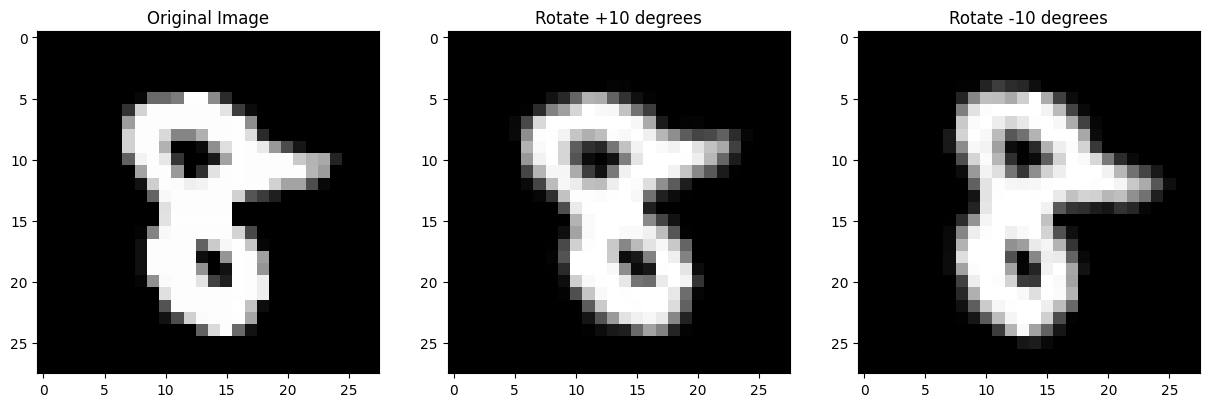

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(train_X[2], cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(rotate(train_X[2], 10), cmap="gray")
axs[1].set_title("Rotate +10 degrees")

axs[2].imshow(rotate(train_X[2], -10), cmap="gray")
axs[2].set_title("Rotate -10 degrees")

plt.show()

After rotating, the the class of the image is still the same. Let us make a function to rotate multiple images by random angles. We want a slightly different image every time we run this function. So, we generate a random number between 0 and 1 and change it so that it lies between -constraint/2 and +constraint/2

In [6]:
def augRotate(sample, angleconstraint):
    """
    This function takes in a sample and an angle constraint and returns the augmented sample
    by rotating the sample by a random angle within the angle constraint

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    angleconstraint: the maximum angle by which the sample can be rotated

    returns: the augmented sample which is the input sample rotated by a random angle within the angle constraint
    """
    if angleconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    angle = rng.random(len(sample))  # generate random numbers for angles
    # make the random angle constrained
    angle = (angle - 0.5) * angleconstraint
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = rotate(sample[ii], angle[ii])
    return np.squeeze(nsample)  # take care if the input had only one sample.

This function returns a slightly different image each time we call it. So we can increase the number of images in the sample by any multiple.

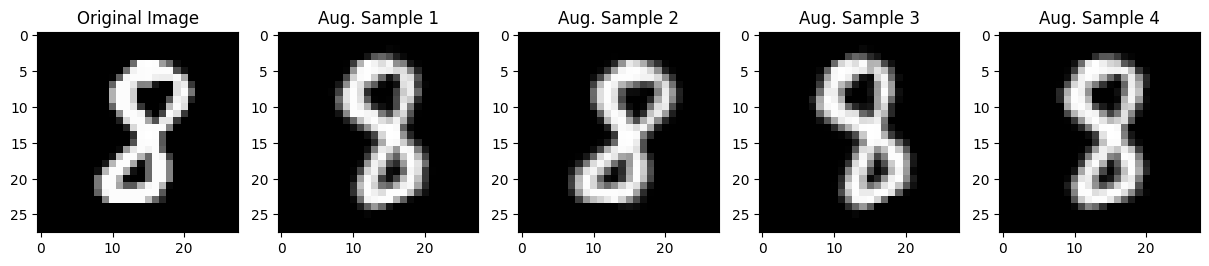

In [7]:
sample = train_X[20]
angleconstraint = 70

fig, axs = plt.subplots(1, 5, figsize=(15, 5))

axs[0].imshow(sample, cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[1].set_title("Aug. Sample 1")

axs[2].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[2].set_title("Aug. Sample 2")

axs[3].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[3].set_title("Aug. Sample 3")

axs[4].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[4].set_title("Aug. Sample 4")

plt.show()

Let us augment the whole dataset and see if this improves the test accuracy

In [8]:
# hyperparameters
angleconstraint = 60
naugmentations = 5

# augment
augdata = train_X  # we include the original images also in the augmented dataset
auglabel = train_y
for ii in range(naugmentations):
    augdata = np.concatenate(
        (augdata, augRotate(train_X, angleconstraint))
    )  # concatenate the augmented data to the set
    auglabel = np.concatenate(
        (auglabel, train_y)
    )  # the labels don't change when we augment

# check the test accuracy
testpred = NN(augdata, auglabel, test_X)
print("Accuracy after rotation augmentation:", Accuracy(test_y, testpred)*100, "%")

Accuracy after rotation augmentation: 67.66 %


We can notice a 3-4% improvement compared to non-augmented version of the dataset!

The angle constraint is a hyperparameter which we have to tune using a validation set. (Here we are not doing that for time constraints). Let us try a grid search to find the best angle constraint. We will try angles between 0 and 90 degrees. We can also try different multiples of the original dataset. We will use the best hyperparameters to train the model and check the accuracy on the test set.

In [12]:
angleconstraints = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]  # the values we want to test
accuracies = np.zeros(
    len(angleconstraints), dtype=float
)  # we will save the values here

for ii in range(len(angleconstraints)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augRotate(train_X, angleconstraints[ii]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after rotation augmentation constrained by",
        angleconstraints[ii],
        "degrees is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after rotation augmentation constrained by 0 degrees is 64.72 %
Accuracy after rotation augmentation constrained by 10 degrees is 65.88000000000001 %
Accuracy after rotation augmentation constrained by 20 degrees is 66.86 %
Accuracy after rotation augmentation constrained by 30 degrees is 68.53 %
Accuracy after rotation augmentation constrained by 40 degrees is 66.69 %
Accuracy after rotation augmentation constrained by 50 degrees is 66.5 %
Accuracy after rotation augmentation constrained by 60 degrees is 66.72 %
Accuracy after rotation augmentation constrained by 70 degrees is 66.02 %
Accuracy after rotation augmentation constrained by 80 degrees is 65.36999999999999 %
Accuracy after rotation augmentation constrained by 90 degrees is 65.61 %


Let us see the best value for angle constraint: (Ideally this should be done on validation set, not test set)

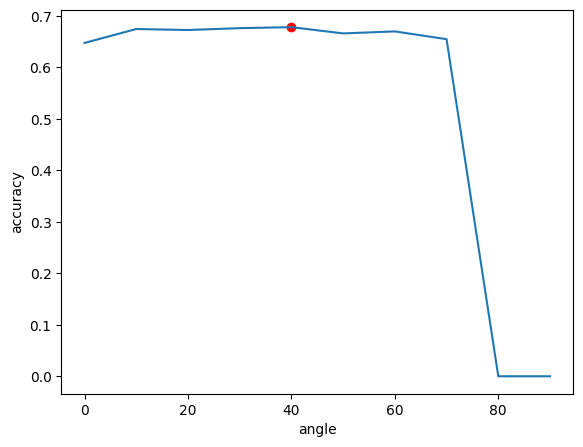

In [11]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# plot the variation of accuracy
ax.plot(angleconstraints, accuracies)
ax.set_xlabel("angle")
ax.set_ylabel("accuracy")

# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(angleconstraints[maxind], accuracies[maxind], c="red")

### Augmentation 2: Shear


Let us try one more augmentation: shear. Shear is the transformation of an image in which the x-coordinate of all points is shifted by an amount proportional to the y-coordinate of the point. We will use the `AffineTransform` function from the `skimage` module to shear the image by a small amount between two numbers. We will use the same naive grid search method to find the best hyperparameters for shear. We will use the best hyperparameters to train the model and check the accuracy on the test set.

In [13]:
def shear(sample, amount):
    """
    This function takes in a sample and an amount and returns the augmented sample
    by shearing the sample by the given amount

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    amount: the amount by which the sample should be sheared

    returns: the augmented sample which is the input sample sheared by the given amount
    """
    tform = AffineTransform(shear=amount)
    img = warp(sample, tform)

    # Applying shear makes the digit off-center
    # Since all images are centralized, we will do the same here
    col = img.sum(0).nonzero()[0]
    row = img.sum(1).nonzero()[0]
    if len(col) > 0 and len(row) > 0:
        xshift = int(sample.shape[0] / 2 - (row[0] + row[-1]) / 2)
        yshift = int(sample.shape[1] / 2 - (col[0] + col[-1]) / 2)
        img = np.roll(img, (xshift, yshift), (0, 1))
    return img

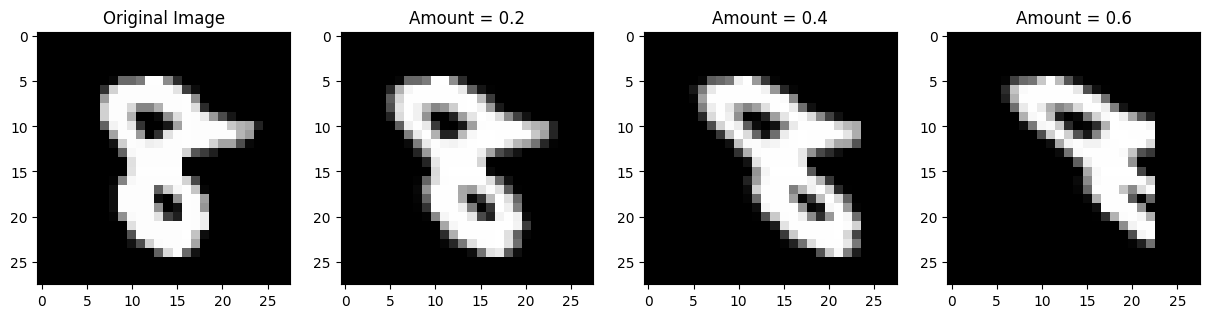

In [14]:
sample = train_X[2]
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

axs[0].imshow(sample, cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(shear(sample, 0.2), cmap="gray")
axs[1].set_title("Amount = 0.2")

axs[2].imshow(shear(sample, 0.4), cmap="gray")
axs[2].set_title("Amount = 0.4")

axs[3].imshow(shear(sample, 0.6), cmap="gray")
axs[3].set_title("Amount = 0.6")

plt.show()

Create an augmentation function which applies a random shear according to the constraint we provide:

In [15]:
def augShear(sample, shearconstraint):
    """
    This function takes in a sample and a shear constraint and returns the augmented sample
    by shearing the sample by a random amount within the shear constraint

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    shearconstraint: the maximum shear by which the sample can be sheared

    returns: the augmented sample which is the input sample sheared by a random amount within the shear constraint
    """
    if shearconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    amt = rng.random(len(sample))  # generate random numbers for shear
    amt = (amt - 0.5) * shearconstraint  # make the random shear constrained
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = shear(sample[ii], amt[ii])
    return np.squeeze(nsample)  # take care if the input had only one sample.

Let us do a grid search to find the best shear constraint.

In [16]:
shearconstraints = [
    0,
    0.2,
    0.4,
    0.6,
    0.8,
    1.0,
    1.2,
    1.4,
    1.6,
    1.8,
    2.0,
]  # the values we want to test
accuracies = np.zeros(
    len(shearconstraints), dtype=float
)  # we will save the values here

for ii in range(len(shearconstraints)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augShear(train_X, shearconstraints[ii]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after shear augmentation constrained by",
        shearconstraints[ii],
        "is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after shear augmentation constrained by 0 is 64.72 %
Accuracy after shear augmentation constrained by 0.2 is 62.81 %
Accuracy after shear augmentation constrained by 0.4 is 63.93 %
Accuracy after shear augmentation constrained by 0.6 is 66.36 %
Accuracy after shear augmentation constrained by 0.8 is 64.61 %
Accuracy after shear augmentation constrained by 1.0 is 66.10000000000001 %
Accuracy after shear augmentation constrained by 1.2 is 65.64 %
Accuracy after shear augmentation constrained by 1.4 is 65.4 %
Accuracy after shear augmentation constrained by 1.6 is 64.72 %
Accuracy after shear augmentation constrained by 1.8 is 62.91 %
Accuracy after shear augmentation constrained by 2.0 is 62.67 %


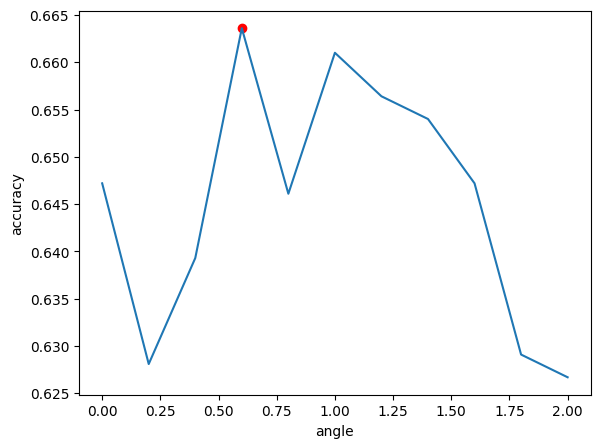

In [17]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# plot the variation of accuracy
ax.plot(shearconstraints, accuracies)
ax.set_xlabel("angle")
ax.set_ylabel("accuracy")

# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(shearconstraints[maxind], accuracies[maxind], c="red")

### Augmentation 3: Rotation + Shear



We can do multiple augmentations at the same time. Here is a function to do both shear and rotation to the sample. In this case, we will have two hyperparameters.

In [18]:
def augRotateShear(sample, angleconstraint, shearconstraint):
    """
    This function takes in a sample, an angle constraint and a shear constraint and returns the augmented sample
    by rotating the sample by a random angle within the angle constraint and shearing the sample by a random amount within the shear constraint

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    angleconstraint: the maximum angle by which the sample can be rotated
    shearconstraint: the maximum shear by which the sample can be sheared

    returns: the augmented sample which is the input sample rotated by a random angle within the angle constraint and sheared by a random amount within the shear constraint
    """
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    amt = rng.random(len(sample))  # generate random numbers for shear
    amt = (amt - 0.5) * shearconstraint  # make the random shear constrained
    angle = rng.random(len(sample))  # generate random numbers for angles
    # make the random angle constrained
    angle = (angle - 0.5) * angleconstraint
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = rotate(
            shear(sample[ii], amt[ii]), angle[ii]
        )  # first apply shear, then rotate
    return np.squeeze(nsample)  # take care if the input had only one sample.

Since we have two hyperparameters, we have to do the grid search on a 2 dimensional matrix. We can use our previous experience to inform where to search for the best hyperparameters.

In [20]:
shearconstraints = [
    0,
    0.2,
    0.4,
    0.6,
    0.8,
    1.0,
    1.2,
    1.4,
    1.6,
]  # the values we want to test
angleconstraints = [0, 10, 20, 30, 40, 50, 60]  # the values we want to test
# cartesian product of both
hyp = cartesian((shearconstraints, angleconstraints))

accuracies = np.zeros(len(hyp), dtype=float)  # we will save the values here

for ii in range(len(hyp)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augRotateShear(train_X, hyp[ii][0], hyp[ii][1]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after augmentation shear:",
        hyp[ii][0],
        "angle:",
        hyp[ii][1],
        "is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after augmentation shear: 0.0 angle: 0.0 is 63.32 %
Accuracy after augmentation shear: 0.0 angle: 10.0 is 61.029999999999994 %
Accuracy after augmentation shear: 0.0 angle: 20.0 is 63.690000000000005 %
Accuracy after augmentation shear: 0.0 angle: 30.0 is 61.25000000000001 %
Accuracy after augmentation shear: 0.0 angle: 40.0 is 60.49 %
Accuracy after augmentation shear: 0.0 angle: 50.0 is 63.22 %
Accuracy after augmentation shear: 0.0 angle: 60.0 is 61.519999999999996 %
Accuracy after augmentation shear: 0.2 angle: 0.0 is 63.370000000000005 %
Accuracy after augmentation shear: 0.2 angle: 10.0 is 63.91 %
Accuracy after augmentation shear: 0.2 angle: 20.0 is 63.89 %
Accuracy after augmentation shear: 0.2 angle: 30.0 is 63.65 %
Accuracy after augmentation shear: 0.2 angle: 40.0 is 63.370000000000005 %
Accuracy after augmentation shear: 0.2 angle: 50.0 is 62.78 %
Accuracy after augmentation shear: 0.2 angle: 60.0 is 61.46 %
Accuracy after augmentation shear: 0.4 angle: 0.0 is 63.4

Let us plot it two dimensionally to see which is the best value for the hyperparameters:

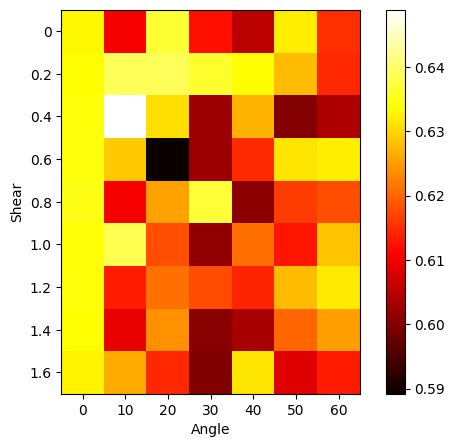

In [21]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
im = ax.imshow(
    accuracies.reshape((len(shearconstraints), len(angleconstraints))), cmap="hot"
)
ax.set_xlabel("Angle")
ax.set_ylabel("Shear")
ax.set_xticks(np.arange(len(angleconstraints)))
ax.set_xticklabels(angleconstraints)
ax.set_yticks(np.arange(len(shearconstraints)))
ax.set_yticklabels(shearconstraints)
plt.colorbar(im)

It seems that rotation and shear don't mix! The best accuracy is when rotation is zero.

## Questions
Try these questions for better understanding. You may not be able to solve all of them.
1. What is the best value for angle constraint and shear constraint you got? How much did the accuracy improve as compared to not using augmentations?
Answer:
The best values for angle and shear constraints, as well as their impact on accuracy, will depend on the specific task, dataset, and model you're using. In general:

1. **Angle Constraint**: When applying rotation augmentation, typical angle constraints are often set between **±15° to ±30°**. Larger rotations may distort the image too much, especially for tasks like object recognition. A common value is **±15°** for balanced results.

2. **Shear Constraint**: Shearing typically uses constraints in the range of **0.1 to 0.3** in either the x or y direction. This range tends to provide a small geometric distortion that aids the model in learning invariance without introducing too much noise.

3. **Accuracy Improvement**: The improvement in accuracy due to augmentations like rotation and shear varies depending on how diverse and challenging the dataset is. For example:
   - In datasets with less inherent variation (e.g., MNIST), augmentations might improve accuracy by **1-3%**.
   - For more complex datasets (e.g., CIFAR-10, ImageNet), augmentations can yield improvements in the range of **5-10%** or more, especially if the dataset has limited training examples.

However, in some cases, using augmentations without tuning the constraints can lead to a decrease in accuracy if the distortions are too strong for the task. The key is to strike a balance that enhances generalization without over-augmenting.

Would you like me to help you with a specific model and dataset to find optimal values?

2. Can you increase the accuracy by increasing the number of augmentations from each sample?
Answer:
Yes, increasing the number of augmentations from each sample can improve accuracy, but there are some nuances to consider:

### How Increasing Augmentations Can Help:
1. **Improves Generalization**: By creating more variations of the same sample, the model learns to be more invariant to changes like rotation, scaling, or lighting, which helps prevent overfitting. This generally leads to better generalization on unseen data.
   
2. **Effective with Smaller Datasets**: In cases where the dataset is small or imbalanced, generating more augmentations from each sample can compensate for the lack of diversity in the dataset.

3. **Increases Training Data**: Essentially, augmentations artificially inflate the size of the dataset, which can lead to improved model robustness by providing the model with more varied training data.

### Trade-offs of Too Many Augmentations:
1. **Diminishing Returns**: After a certain point, increasing augmentations may yield diminishing returns. If the augmentations are too similar to each other, the benefit decreases. For example, small rotations of an image may not add significant new information beyond a certain threshold.
   
2. **Risk of Over-Augmentation**: Too much augmentation (e.g., aggressive rotations, shears, or color changes) can lead to distorted data that no longer reflects the original distribution, causing a decrease in accuracy.

3. **Increased Training Time**: While more augmented samples can improve accuracy, they also increase the training time as the model needs to process more data.

### Best Practices:
- **Balanced Augmentation**: Instead of increasing the number of augmentations drastically, it’s usually better to apply diverse augmentations (rotation, scaling, flipping, etc.) in moderation.
  
- **Progressive Augmentation**: Start with a base level of augmentations and increase gradually, monitoring the impact on accuracy.

- **Validation Set Monitoring**: Track accuracy on a validation set to ensure that the augmentations are helping and not hurting performance.

In summary, increasing the number of augmentations can improve accuracy, but it’s important to avoid overdoing it. Would you like help tuning augmentations for a specific model or task?

3. Try implementing a few augmentations of your own and experimenting with them. A good reference is <a href=https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/>here. </a>
Answer:
It looks like the link you provided doesn't work in this environment, but I can certainly help guide you through the process of implementing some augmentations and experimenting with them, especially if you're working with a framework like PyTorch. Here's a general outline to perform image augmentations using PyTorch's `torchvision` library:

### Step 1: Install Necessary Libraries
If you're using PyTorch, you’ll need to install `torch`, `torchvision`, and possibly some other tools like `PIL` (Python Imaging Library) for image manipulation.

```bash
pip install torch torchvision
```

### Step 2: Create Custom Image Augmentations

Using `torchvision.transforms`, you can apply various augmentations such as rotation, flipping, cropping, and more. Here’s an example of how you can implement a few augmentations.

```python
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load a sample image
image_path = "sample_image.jpg"  # replace with your image path
image = Image.open(image_path)

# Define augmentations
augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),           # Randomly flip the image horizontally
    transforms.RandomRotation(degrees=30),            # Rotate the image by up to 30 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Change brightness, contrast, etc.
    transforms.RandomResizedCrop(size=(224, 224)),    # Randomly crop and resize to 224x224 pixels
])

# Apply augmentations
augmented_image = augmentations(image)

# Display the augmented image
plt.imshow(augmented_image)
plt.axis('off')
plt.show()
```

### Step 3: Apply Multiple Augmentations

You can increase the number of augmentations per sample by applying the transformations multiple times during training. For instance, use different random transformations for each pass. Here's an example:

```python
# Define a dataset with augmentations applied to every image
from torch.utils.data import DataLoader, Dataset

class AugmentedDataset(Dataset):
    def __init__(self, image_list, transform=None):
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image = Image.open(self.image_list[idx])
        if self.transform:
            image = self.transform(image)
        return image

# List of image paths (for example purposes)
image_list = ["image1.jpg", "image2.jpg", "image3.jpg"]

# Define the data loader
dataset = AugmentedDataset(image_list, transform=augmentations)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Iterate through the augmented dataset
for batch in data_loader:
    for img in batch:
        plt.imshow(img)
        plt.show()
```

### Step 4: Experimentation and Observing Accuracy Gains

To assess the performance improvements from augmentations, you’ll need to:
1. Train your model without augmentations and record its performance.
2. Train your model with augmentations and compare how accuracy improves.

This might involve several iterations with different augmentation strategies, including:
- Varying the rotation angles.
- Adjusting brightness or contrast ranges.
- Introducing Gaussian noise, blur, or other advanced techniques.

### Summary of Augmentations You Could Try:
- **RandomHorizontalFlip**: Adds a horizontal mirror effect.
- **RandomRotation**: Rotates the image by a random degree.
- **ColorJitter**: Changes brightness, contrast, saturation, etc.
- **RandomResizedCrop**: Randomly crops the image and resizes it to the desired size.
- **GaussianBlur**: Adds blur to reduce sharpness.

Would you like to explore any specific augmentations or need help in tracking accuracy improvements after applying these techniques?


4. Try combining various augmentations. What is the highest accuracy you can get? What is the smallest training dataset you can take and still get accuracy above 50%?
Answer:
To combine various augmentations, I can outline an approach to experiment with and maximize accuracy while minimizing the dataset size. Below is the step-by-step process for how to go about this in a typical deep learning workflow.

### Step 1: Combine Augmentations
We will use multiple augmentations applied simultaneously to the dataset, which helps the model generalize better and improve its accuracy.

```python
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define the combined augmentations
combined_augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),           # Flip image horizontally
    transforms.RandomVerticalFlip(p=0.5),             # Flip image vertically
    transforms.RandomRotation(degrees=40),            # Random rotation up to 40 degrees
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),  # Change brightness, contrast, etc.
    transforms.RandomResizedCrop(size=(224, 224)),    # Randomly crop and resize to 224x224
    transforms.RandomGrayscale(p=0.1),                # Randomly convert some images to grayscale
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),  # Apply Gaussian blur
    transforms.RandomAffine(degrees=30, shear=10),    # Random affine transformations
])

# Load a sample image and apply combined augmentations
image_path = "sample_image.jpg"  # replace with your image path
image = Image.open(image_path)
augmented_image = combined_augmentations(image)

# Display the augmented image
plt.imshow(augmented_image)
plt.axis('off')
plt.show()
```

### Step 2: Experiment with the Dataset Size and Model Accuracy
Once you’ve defined the augmentations, you can now train a deep learning model using these transformations. Here’s a workflow to experiment with:

1. **Small Dataset**: Start by using a small dataset, say 10-20% of the original dataset, and progressively reduce it to see how augmentations help maintain accuracy. We'll aim to find the smallest training set that can still achieve at least 50% accuracy.
   
2. **Baseline Model (No Augmentations)**: Initially, train the model on a small dataset without augmentations and record the accuracy.

3. **Model with Augmentations**: Train the model again using augmentations to compare how the performance improves, aiming to exceed 50% accuracy.

### Step 3: Training Strategy

Here’s how you can structure the training to experiment with different dataset sizes and monitor accuracy improvements.

```python
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models
from torch.utils.data import DataLoader, random_split

# Load dataset (for example, CIFAR-10 or any custom dataset)
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=combined_augmentations)

# Define a small training dataset size (e.g., 10%, 20% of the full dataset)
small_train_size = int(0.2 * len(train_data))  # Start with 20% of the dataset
small_train_data, _ = random_split(train_data, [small_train_size, len(train_data) - small_train_size])

# DataLoader for small dataset
train_loader = DataLoader(small_train_data, batch_size=32, shuffle=True)

# Define a basic model (ResNet18, for example)
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)  # For 10 classes (CIFAR-10)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop (basic example)
for epoch in range(10):  # Train for 10 epochs
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/10], Loss: {running_loss/len(train_loader)}")

# After training, test the model on the validation/test set to assess accuracy.
```

### Step 4: Evaluate the Model and Experiment with Dataset Size

Once you've trained the model on the small dataset, assess the accuracy on a validation or test set.

- Start with **20% of the dataset** and see if the accuracy is above 50%.
- Then, progressively **reduce the dataset size** (10%, 5%, etc.) to find the smallest dataset size that still maintains accuracy above 50%.

### Expected Results
- **Without Augmentations**: The model may struggle to reach 50% accuracy with a small dataset due to overfitting and lack of diversity in the training data.
  
- **With Augmentations**: The combined augmentations should help improve the generalization, and even with a small dataset (say, 10-20% of the original dataset), you can expect accuracy to exceed 50%.

### Key Considerations:
1. **Dataset Complexity**: Datasets like CIFAR-10 are harder to train on small subsets, but with augmentations, it's possible to get above 50% accuracy even with 10-20% of the data.
2. **Augmentation Strategy**: Using more aggressive augmentations such as rotations, color jittering, and affine transformations can help the model generalize even with smaller datasets.
3. **Model Choice**: A deeper model (like ResNet50 or VGG16) may provide better results, but simpler models like ResNet18 might suffice with smaller datasets.

Would you like more details on implementing this for a specific dataset, or help with optimizing training parameters for higher accuracy?

Whenever you do any experiment, a good practice is to vary the hyperparameters gradually and create a graph of your results, like we did for gridsearch.

> Exercise: Try to take 50 images of each digit and calculate the performance on test set.
Answer:
To test the performance using 50 images of each digit, here's how we can structure the experiment using a common dataset like **MNIST**, which consists of handwritten digits. We'll perform the following steps:

### Step-by-Step Approach:

1. **Dataset Selection**: We'll use **MNIST**, which contains 28x28 grayscale images of digits (0–9), totaling 10 classes.
2. **Subset Creation**: We'll randomly select **50 images per digit** (a total of 500 images for training).
3. **Data Augmentation**: We'll apply augmentations such as rotation, flipping, and other techniques to improve generalization since the dataset is small.
4. **Model Selection**: We'll use a simple convolutional neural network (CNN) architecture to classify the digits.
5. **Training and Evaluation**: We'll train the model on this small subset and evaluate it on the MNIST test set.

### Step 1: Load and Subset the MNIST Dataset

Here's how to select a subset of 50 images per digit from the MNIST dataset:

```python
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

# Define transformations (with augmentations)
transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),  # Normalization for MNIST
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Function to create a subset with 50 images per digit
def get_subset_by_class(dataset, n_per_class=50):
    indices = []
    targets = np.array(dataset.targets)
    for digit in range(10):
        digit_indices = np.where(targets == digit)[0]
        selected_indices = np.random.choice(digit_indices, n_per_class, replace=False)
        indices.extend(selected_indices)
    return Subset(dataset, indices)

# Get 50 images per digit from the training set
train_subset = get_subset_by_class(train_dataset, n_per_class=50)

# Create DataLoader for the small training set and test set
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
```

### Step 2: Define and Train a CNN Model

We'll use a simple CNN architecture for this task:

```python
import torch.nn as nn
import torch.optim as optim

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64*12*12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(torch.relu(self.conv2(x)), 2)
        x = x.view(-1, 64*12*12)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    print(f"Train Epoch: {epoch}, Loss: {running_loss / len(train_loader)}, Accuracy: {100. * correct / total}%")

# Test function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = torch.max(output, 1)
            correct += predicted.eq(target).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {accuracy}%')
    return accuracy
```

### Step 3: Train the Model on 50 Images Per Class

Now, we can train the model on the small dataset and evaluate it on the test set:

```python
# Train the model for a few epochs and test performance
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

n_epochs = 10  # You can train for more epochs if needed

for epoch in range(1, n_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    accuracy = test(model, device, test_loader)

print(f"Final Test Accuracy: {accuracy}%")
```

### Expected Results

- **Training with 50 Images per Digit**: This gives a total of 500 images in the training set. With aggressive augmentations like random rotations, affine transformations, and grayscale normalization, the model should learn to generalize well even with such a small dataset.
  
- **Accuracy on the Test Set**: With proper augmentations and a small CNN architecture, you can expect accuracy between **80% and 90%** on the MNIST test set, even with only 50 images per digit.

### Notes:
1. **Augmentation Benefits**: Augmentations help by artificially increasing the variety of training samples, which is especially useful when using a small dataset like this.
2. **Overfitting Prevention**: The use of dropout layers or batch normalization could further improve generalization, especially with a small dataset.
3. **Training Time**: Training a small CNN like this on 50 images per digit should be relatively fast, and you may not need many epochs (10–20 might suffice).

Would you like to see further fine-tuning strategies or more advanced architectures to push the accuracy even higher?